In [13]:
#import freud, mdtraj
#import MDAnalysis as mda
import numpy as np
from scipy.spatial import cKDTree, Voronoi, voronoi_plot_2d
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import networkx as nx

a = 1.42


In [14]:
def find_dynamic_cutoff(positions):
    """
    1) For each atom, query its 4 nearest neighbors (self + 3 true bonds).
    2) Collect all of the 3rd‐neighbor distances.
    3) Take the median of those as the canonical C–C bond length.
    4) Return 1.5× that median as a safe radius.
    """
    tree = cKDTree(positions)
    dists, idxs = tree.query(positions, k=4)   # dists[:,0]==0 (self)
    third = dists[:,3]                          # distance to the 3rd neighbor
    bond_len = np.median(third)
    return 1.15*bond_len

def NN(positions, _dummy=None):
    """
    1) Compute R = dynamic cutoff from find_dynamic_cutoff().
    2) Find *all* neighbors within R via the cKDTree.
    3) For each atom, sort its neighbors by distance and *take the 3 closest*.
    4) Symmetrize the graph so (i→j) ⇔ (j→i).
    """
    tree = cKDTree(positions)
    R = find_dynamic_cutoff(positions)

    # 2) ball query
    raw = tree.query_ball_point(positions, r=R)

    N = len(positions)
    neigh = [None]*N
    for i, cand in enumerate(raw):
        # compute distances to the candidates
        ds = np.linalg.norm(positions[cand] - positions[i], axis=1)
        # pair and sort, dropping self if present
        pairs = sorted(zip(cand, ds), key=lambda x: x[1])
        # drop the self‐distance of zero if it sneaks in
        pairs = [p for p in pairs if p[0]!=i]
        # take at most 3 true nearest
        picks = [p[0] for p in pairs[:3]]
        neigh[i] = set(picks)

    # 4) symmetrize
    for i, nbrs in enumerate(neigh):
        for j in list(nbrs):
            neigh[j].add(i)

    return [list(s) for s in neigh]


def theta_ij(xi, yi, xj, yj):
    dx = xj - xi
    dy = yj - yi
    return np.arctan2(dy,dx)

# --- Helper function: simple ring-finding based on DFS ---
def find_rings(adjacency, max_cycle_size=8):
    """
    Find all simple cycles (rings) in an undirected graph represented by an adjacency list.
    Returns a set of frozensets, each representing a ring (order is disregarded).
    """
    N = len(adjacency)
    found_rings = set()

    def dfs(start, current_path, visited_set):
        if len(current_path) > max_cycle_size:
            return
        current = current_path[-1]
        for nbr in adjacency[current]:
            if nbr == start and len(current_path) >= 3:
                # Found a cycle: sort the path to create a canonical representation
                ring = frozenset(current_path)
                found_rings.add(ring)
            elif nbr not in visited_set:
                dfs(start, current_path + [nbr], visited_set | {nbr})

    for i in range(N):
        dfs(i, [i], {i})
    return found_rings

# --- Helper function: reorder a ring into a cyclic path ---
def reorder_ring(ring_nodes, positions):
    """
    Given a set or list of nodes that form a cycle, return a list of nodes
    ordered such that consecutive nodes are (approximately) neighbors in space.
    A simple greedy approach is used.
    """
    ring_nodes = list(ring_nodes)
    if len(ring_nodes) < 3:
        return ring_nodes
    # Start with the leftmost node
    ring_nodes.sort(key=lambda i: (positions[i, 0], positions[i, 1]))
    ordered = [ring_nodes[0]]
    used = set(ordered)
    while len(ordered) < len(ring_nodes):
        last = ordered[-1]
        # Choose the remaining node closest to the last one.
        next_node = min([i for i in ring_nodes if i not in used],
                        key=lambda i: np.linalg.norm(positions[i]-positions[last]))
        ordered.append(next_node)
        used.add(next_node)
    return ordered

def plot_lattice(positions, random_atom, random_index, neighbor_list, neighbor_indices, zoom, atom_numbers, fname="picture", inset_chunk_size=10.0):
    """Plot the lattice; if zoom is True, add an inset combining:
    - a small crystal chunk around the chosen atom,
    - and the bond-angle view within that chunk, with a reference axis and angle arcs."""
    
    N = len(positions)
    # Build edge list
    edges = [(i, j) for i in range(N) for j in neighbor_list[i] if j > i]

    fig, ax = plt.subplots(figsize=(10, 10))
    # Plot full lattice
    ax.scatter(positions[:,0], positions[:,1], s=5, c='k', alpha=0.3)
    ax.set_xlabel('x (Å)')
    ax.set_ylabel('y (Å)')
    ax.axis('equal')

    # Plot rings
    for ring in find_rings(neighbor_list, max_cycle_size=8):
        ordered = reorder_ring(ring, positions)
        coords = positions[ordered + [ordered[0]]]
        if len(ring) == 6:
            col, lw, zo = 'blue', 1, 1
        elif len(ring) in (5,7,8):
            col, lw, zo = 'red', 1.5, 3   # <-- higher zorder
        else:
            col, lw, zo = 'orange', 1, 2

        ax.plot(coords[:,0], coords[:,1],
                '-', color=col,
                linewidth=lw,
                zorder=zo)

    # Highlight chosen atom
    if zoom:
        x0, y0 = random_atom
        ax.scatter(x0, y0, color='red', s=80, zorder=5)

        # Inset: chunk + bond-angles
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        from matplotlib.patches import Arc
        ax_ins = inset_axes(ax, width="25%", height="25%", loc='upper right', borderpad=3)

        half = 0.6*inset_chunk_size
        # select atoms in chunk
        mask = (np.abs(positions[:,0]-x0)<=half) & (np.abs(positions[:,1]-y0)<=half)
        pts = positions[mask]
        # plot chunk
        ax_ins.scatter(pts[:,0], pts[:,1], s=8, c='gray')
        for i, j in edges:
            if mask[i] and mask[j]:
                xi, yi = positions[i]; xj, yj = positions[j]
                ax_ins.plot([xi, xj], [yi, yj], 'k-', lw=0.7)

        # center atom & neighbors
        ax_ins.scatter([x0], [y0], color='red', s=60, zorder=5)
        nb = positions[neighbor_indices]
        ax_ins.scatter(nb[:,0], nb[:,1], color='blue', s=50, zorder=5)

        # reference axis
        axis_len = inset_chunk_size * 0.2
        ax_ins.plot([x0, x0+axis_len], [y0, y0], 'k--', lw=1)

        # draw bonds and annotate angles radially
        angles = []
        for j in neighbor_indices:
            xj, yj = positions[j]
            theta = theta_ij(x0, y0, xj, yj)
            angles.append(theta)
            # bond dashed
            ax_ins.plot([x0, xj], [y0, yj], 'g--', lw=1)
        
        # radial label and arc for each angle (use first for arc)
        r = inset_chunk_size * 0.3
        for idx, theta in enumerate(angles):
            # label at 1.1*r
            lx = x0 + 0.9*r * np.cos(theta)
            ly = y0 + 0.73*r * np.sin(theta)
            ax_ins.text(lx, ly, f"{np.degrees(theta):.1f}°", fontsize=10,c="green", ha='center', va='center', zorder=10)


        # clean up inset
        ax_ins.set_xlim(x0-half, x0+half)
        ax_ins.set_ylim(y0-half, y0+half)
        ax_ins.set_xticks([])
        ax_ins.set_yticks([])
    plt.savefig(f'../output/{fname}.pdf', bbox_inches='tight')
    plt.show()


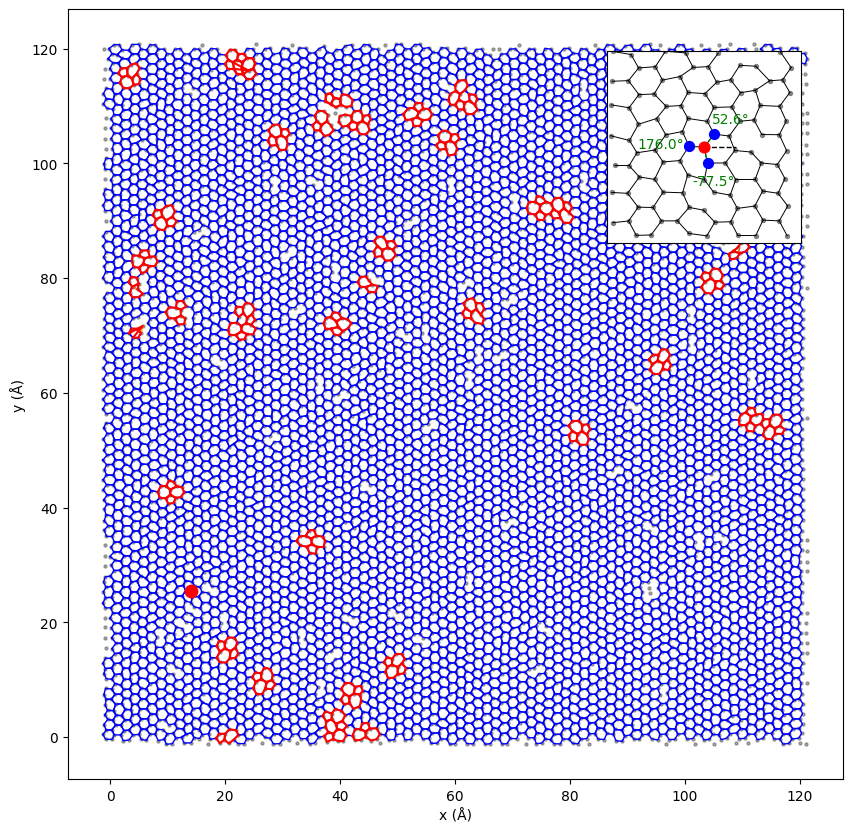

In [212]:
data = np.loadtxt("data/thermal/8125K.txt")
a = 1.42
pos = data[:,2:4] / a
atom_numbers = data[:, 0].astype(int)
neighs = NN(pos)
idx = 450
plot_lattice(pos, pos[idx], idx, neighs, neighs[idx], True, atom_numbers, fname ="8125K")

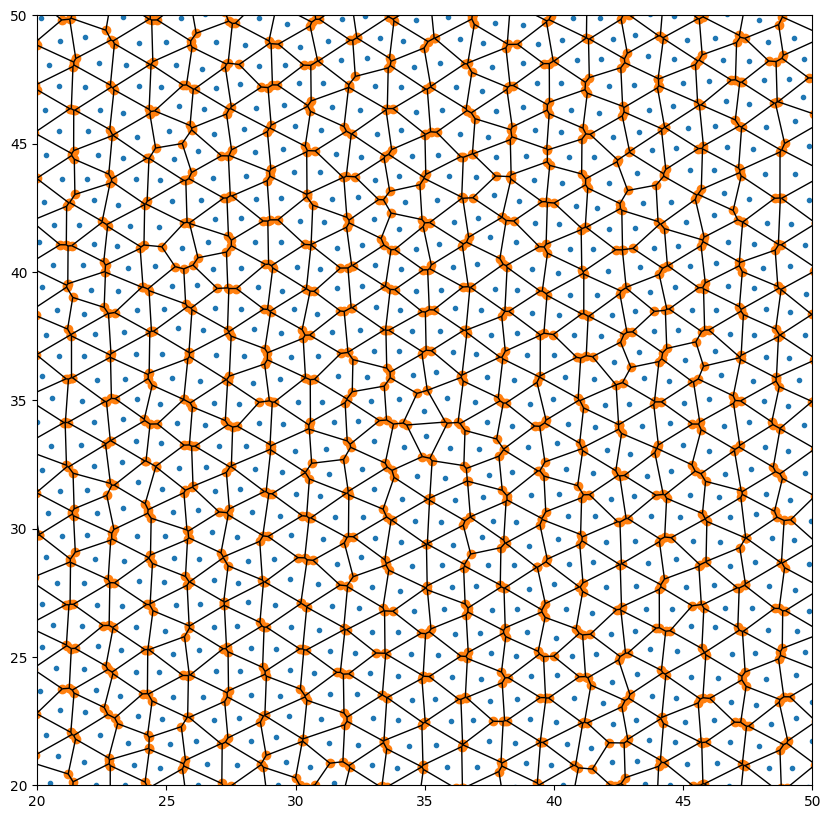

In [214]:
# --- 2) compute Voronoi diagram ---
vor = Voronoi(pos)

# --- 3) plot it ---
fig, ax = plt.subplots(figsize=(10,10))
# draws both the ridges and the finite regions
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='k', line_width=1)
plt.xlim(20,50)
plt.ylim(20,50)
plt.savefig("voronoi_8125K.pdf")

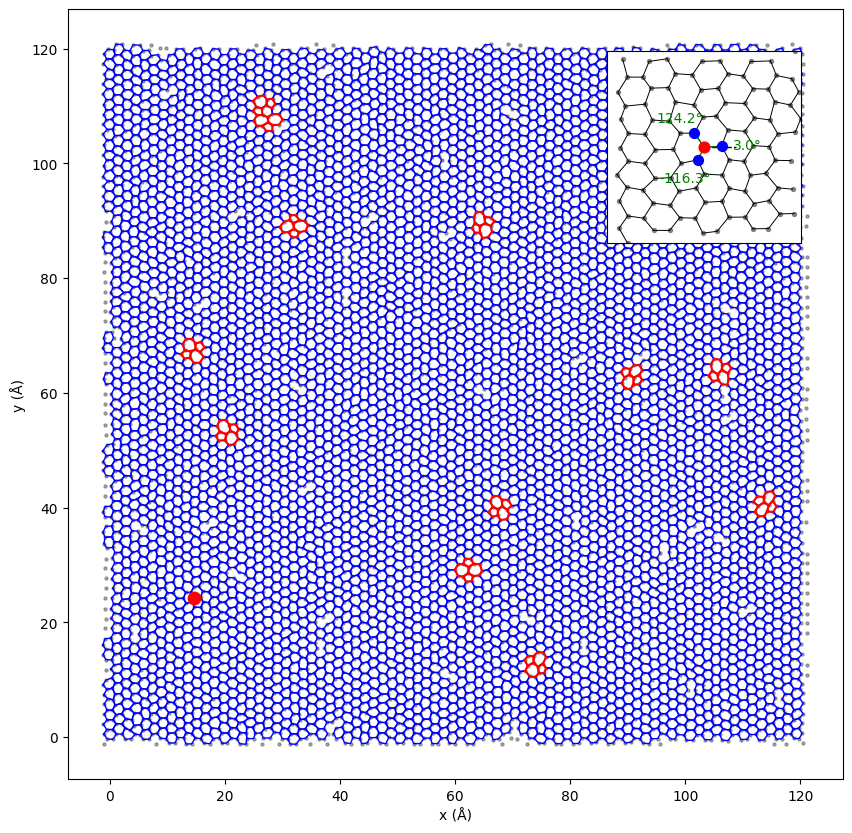

In [215]:
data = np.loadtxt("data/thermal/7000K.txt")
a = 1.42
pos = data[:,2:4] / a
atom_numbers = data[:, 0].astype(int)
neighs = NN(pos)
idx = 450
plot_lattice(pos, pos[idx], idx, neighs, neighs[idx], True, atom_numbers, fname ="7000K")

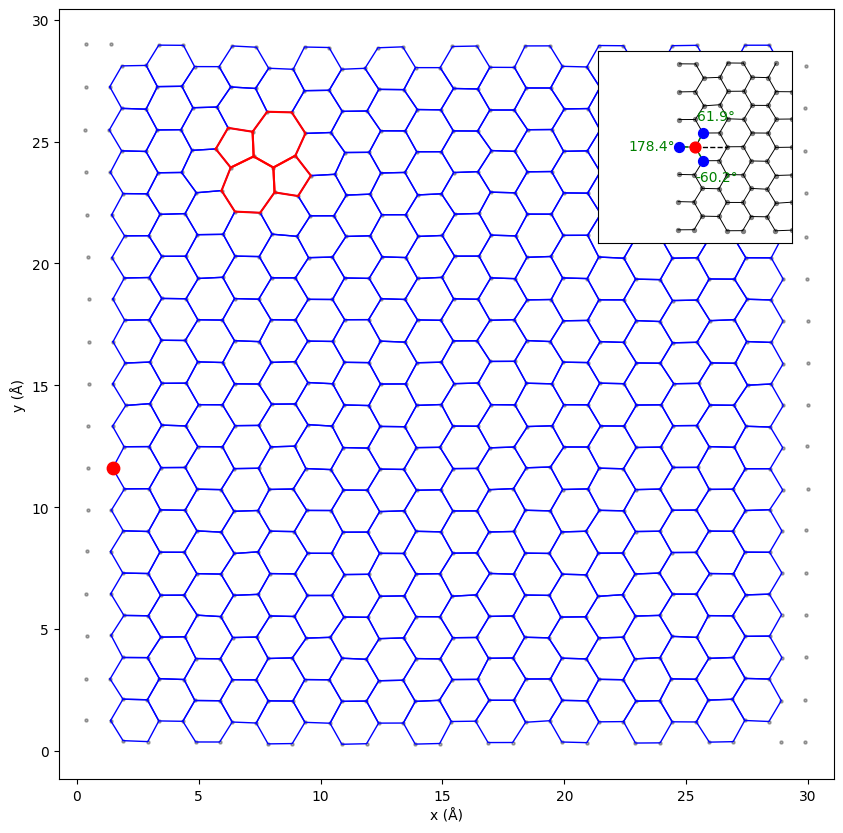

In [16]:
data = np.loadtxt("../output/GAMMAS/8200/anneal_8200K.data",skiprows=14)
N = 680
a = 1.42
pos = data[:,2:4] / a   
atom_numbers = data[:, 0].astype(int)
neighs = NN(pos)
idx = 50
plot_lattice(pos, pos[idx], idx, neighs, neighs[idx], True, atom_numbers, fname ="7000K")

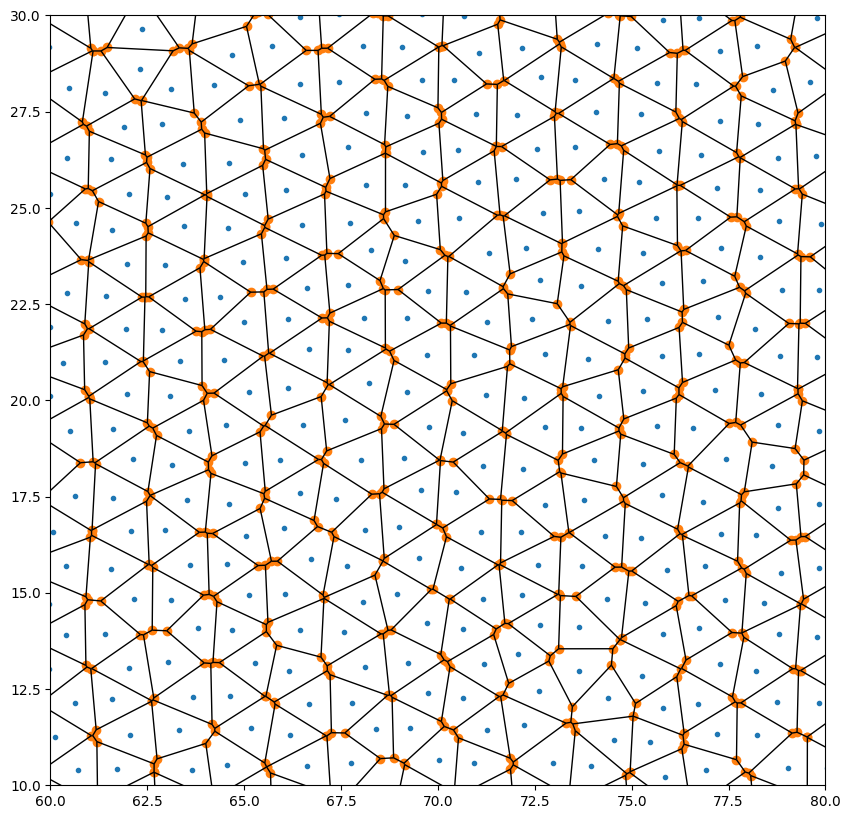

In [216]:
# --- 2) compute Voronoi diagram ---
vor = Voronoi(pos)

# --- 3) plot it ---
fig, ax = plt.subplots(figsize=(10,10))
# draws both the ridges and the finite regions
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='k', line_width=1)
plt.xlim(60,80)
plt.ylim(10,30)
plt.savefig("voronoi_7000K.pdf")

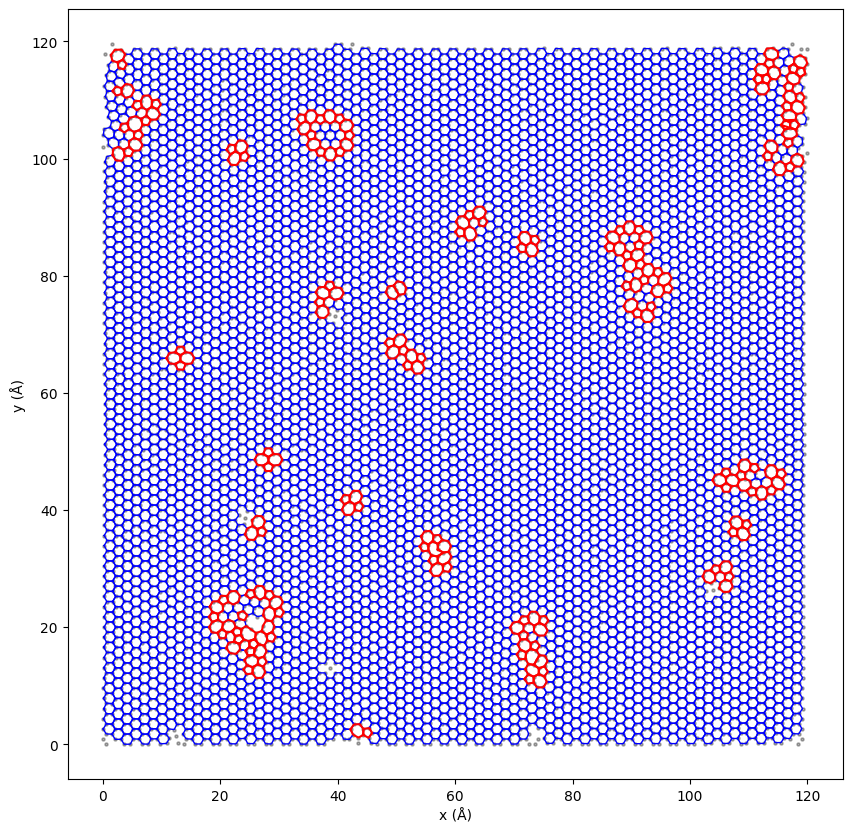

In [ ]:
data = np.loadtxt("data/thermal/9000K.txt")
a = 1.42
pos = data[:,2:4] / a
atom_numbers = data[:, 0].astype(int)
neighs = NN(pos)
idx = 450
plot_lattice(pos, pos[idx], idx, neighs, neighs[idx], False, atom_numbers, fname ="8500K")

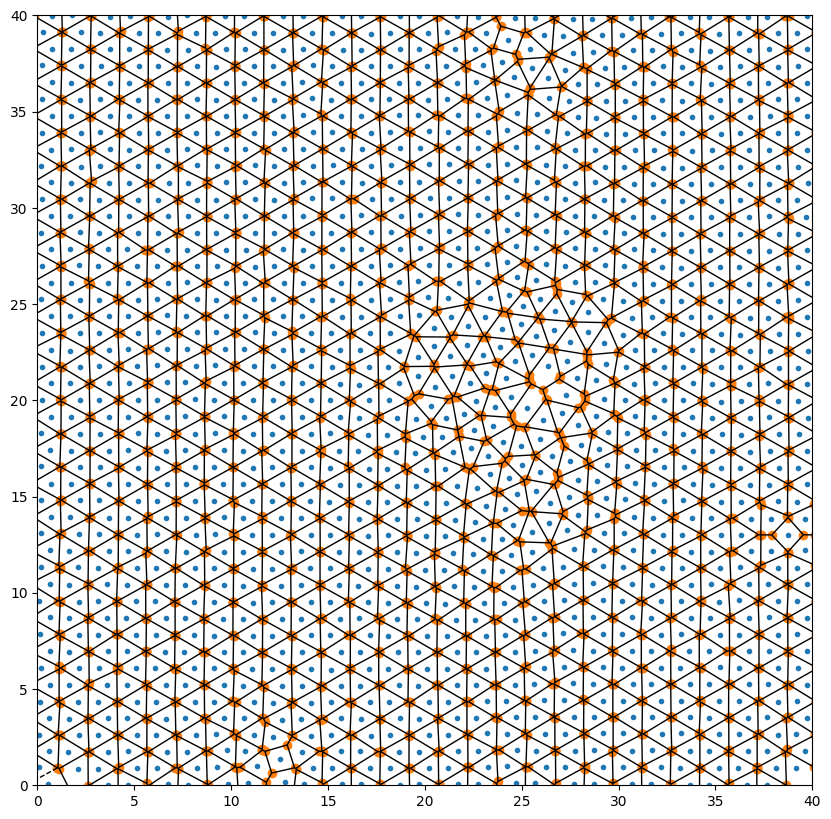

In [19]:
# --- 2) compute Voronoi diagram ---
vor = Voronoi(pos)

# --- 3) plot it ---
fig, ax = plt.subplots(figsize=(10,10))
# draws both the ridges and the finite regions
voronoi_plot_2d(vor, ax=ax, show_vertices=True, line_colors='k', line_width=1)
plt.xlim(0,40)
plt.ylim(0,40)
plt.savefig("voronoi_8500K.pdf")

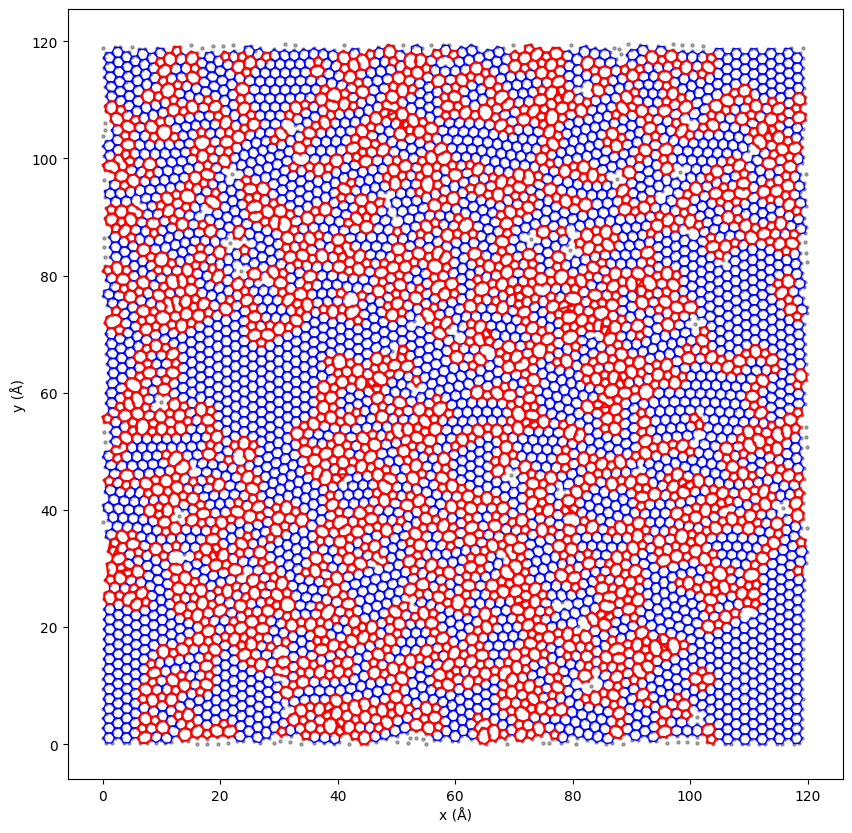

In [36]:
T = 10350
data = np.loadtxt(f"../output/GAMMAS/{T}/anneal_{T}K.data",skiprows=15)
a = 1.42
pos = data[:,2:4] / a
atom_numbers = data[:, 0].astype(int)
neighs = NN(pos)
idx = 450
plot_lattice(pos, pos[idx], idx, neighs, neighs[idx], False, atom_numbers, fname ="8500K")

S(k)

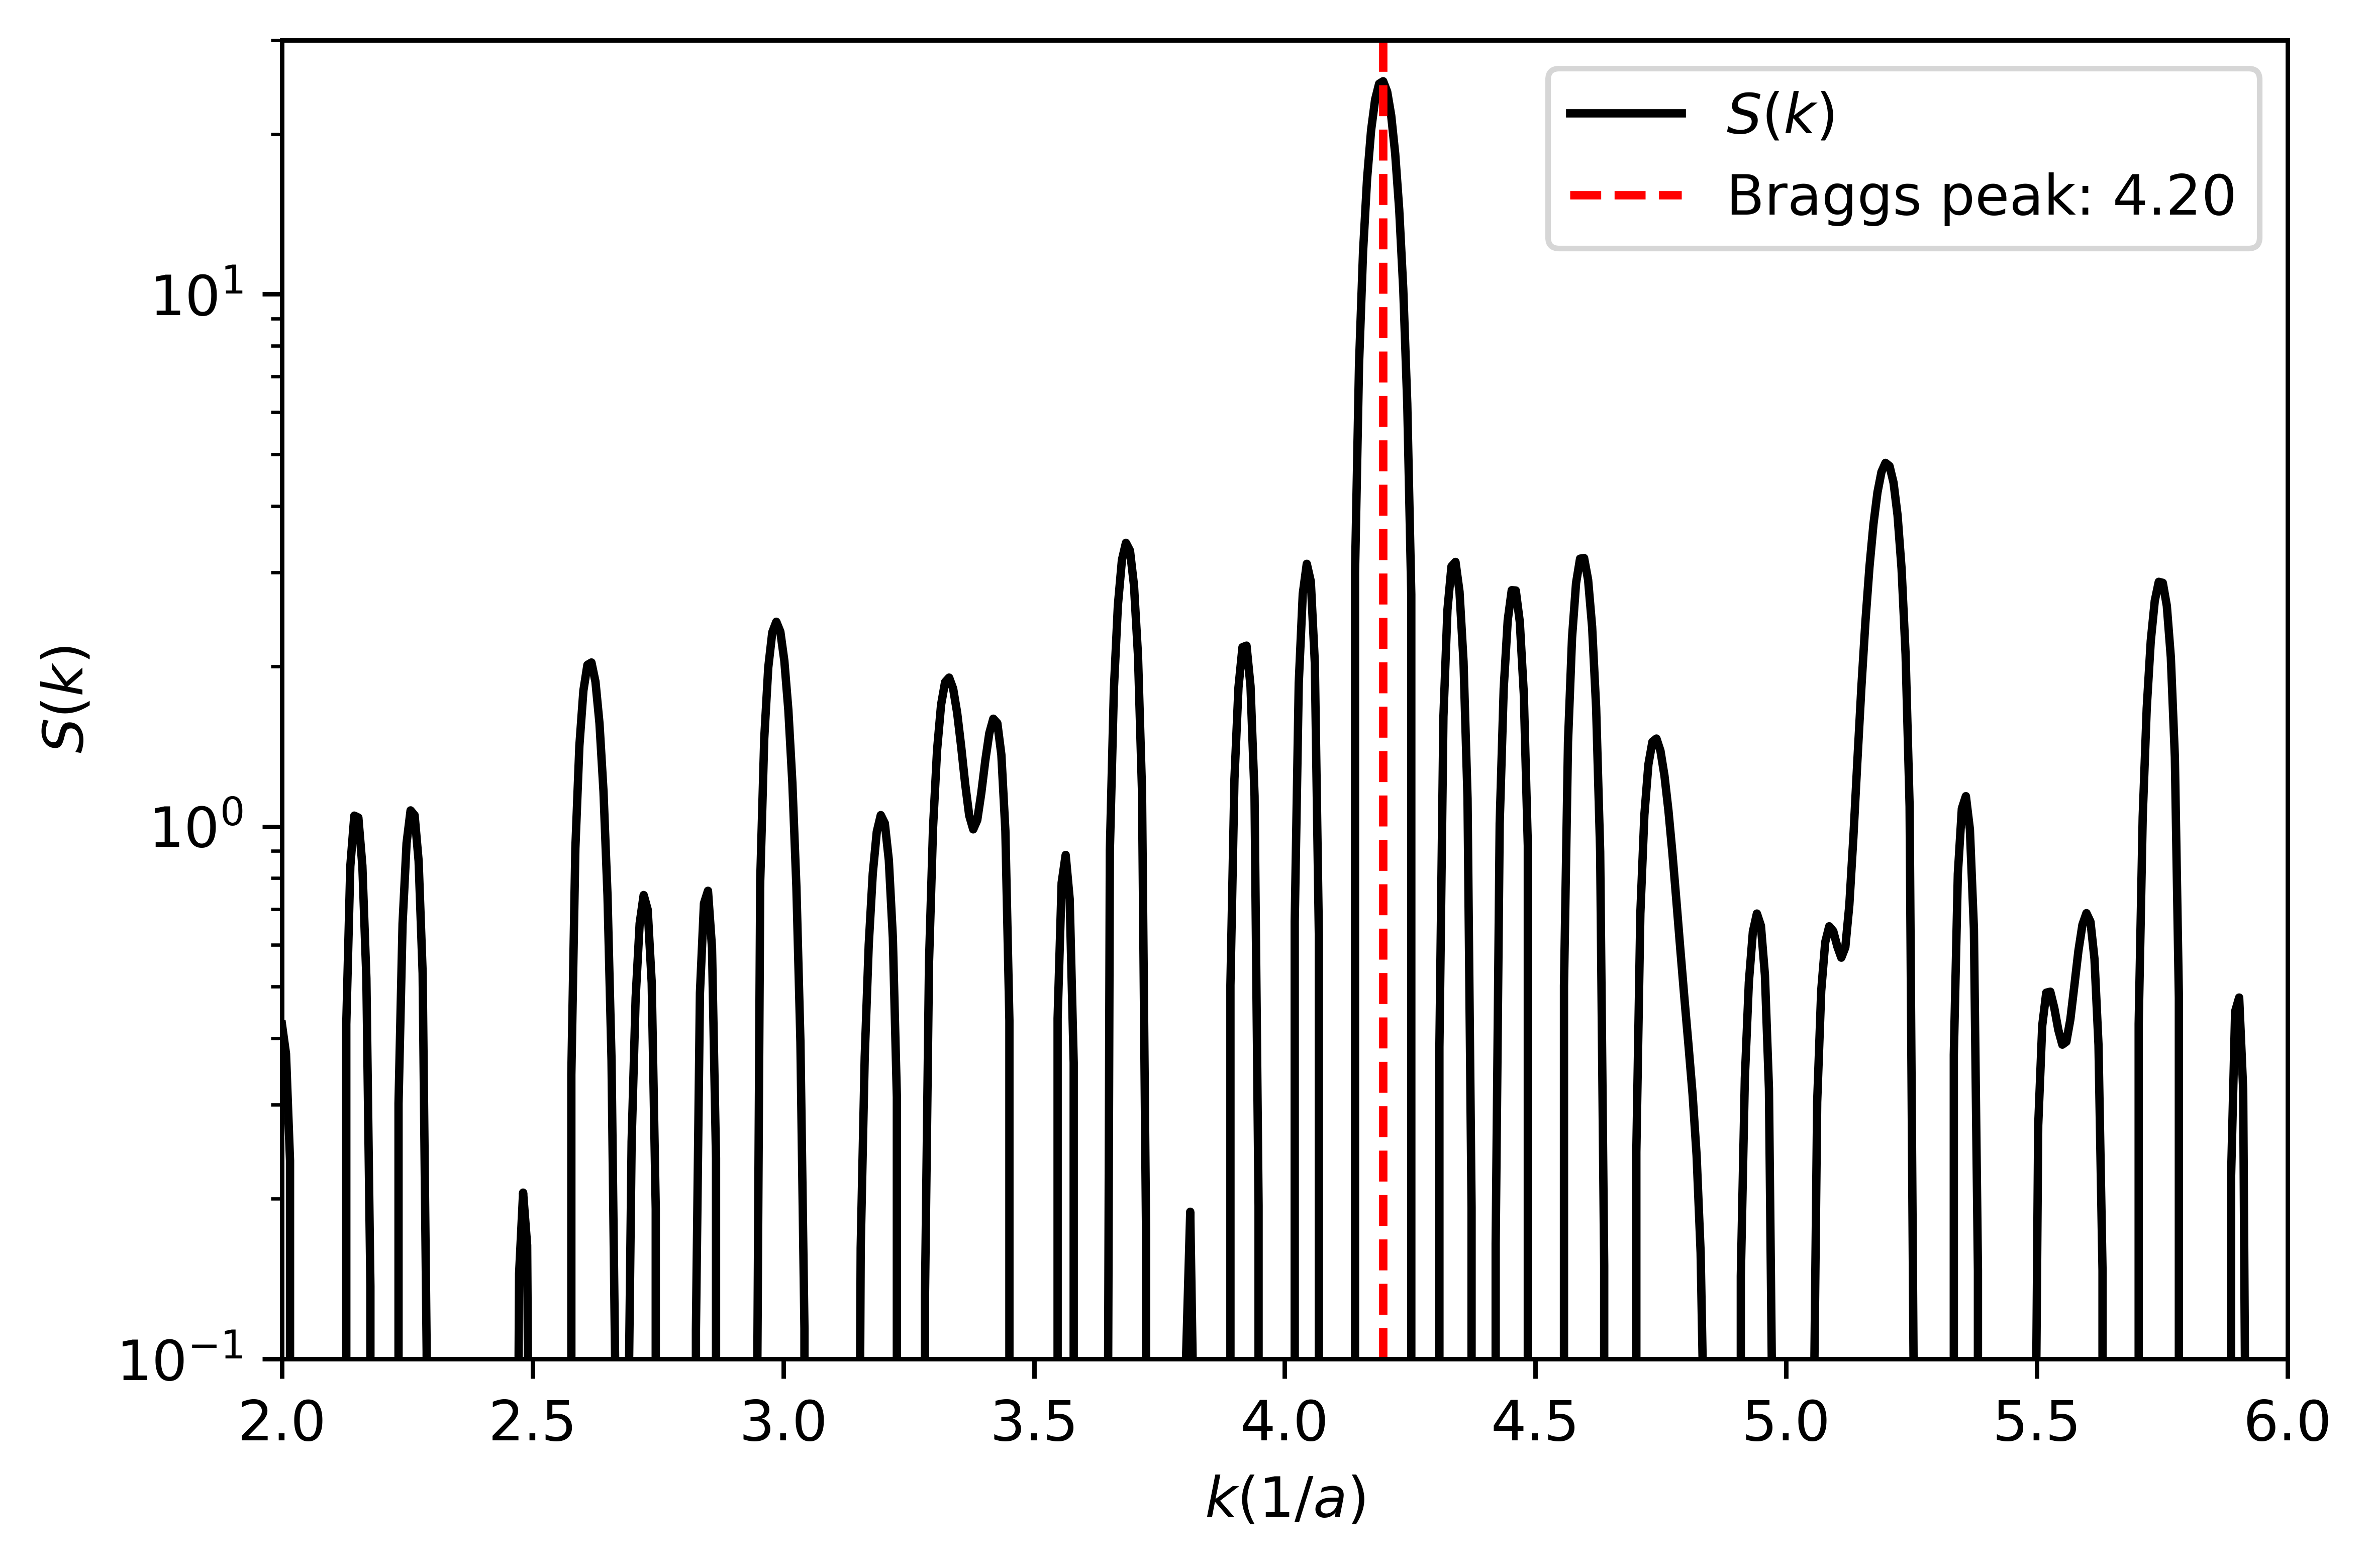

In [ ]:
from scipy.special import j0
from rdfpy import rdf

pos = np.loadtxt("data/crystal.txt")[:,2:4]/a
g_r, r = rdf(pos, dr=0.1)

Lx, Ly = np.ptp(pos[:,0]), np.ptp(pos[:,1])
rho = pos.shape[0] / (Lx * Ly)
dr  = r[1] - r[0]

# prepare the integrand weights: w_j = 2π ρ [g(r_j)-1] r_j Δr
w = 2 * np.pi * rho * (g_r - 1.0) * r * dr

# choose your k‐grid
kmin, kmax, n_k = 2.0, 6.0, 500
ks = np.linspace(kmin, kmax, n_k)

# build the Bessel‐kernel matrix: J[i,j] = J0(k_i * r_j)
J = j0(np.outer(ks, r))    # shape (n_k, nr)

# compute S(k) in one shot:  S_k = 1 + J @ w
S_k = 1.0 + J.dot(w)

# find the strongest peak (excluding k=0)
idx_peak = np.argmax(S_k)
k_peak   = ks[idx_peak]

# plot
plt.figure(figsize=(6,4),dpi=800)
plt.plot(ks, gaussian_filter1d(S_k,sigma=2.0), lw=1.5, label='$S(k)$', c='k')
plt.axvline(k_peak, ls='--', c='red', label=f'Braggs peak: {k_peak:.2f}')
plt.yscale('log')
plt.xlim(kmin, kmax)
plt.ylim((10E-2, 30))
plt.xlabel(r'$k (1/a)$')
plt.ylabel(r'$S(k)$')
plt.legend()
plt.savefig("Braggs.pdf")
plt.tight_layout()
plt.show()

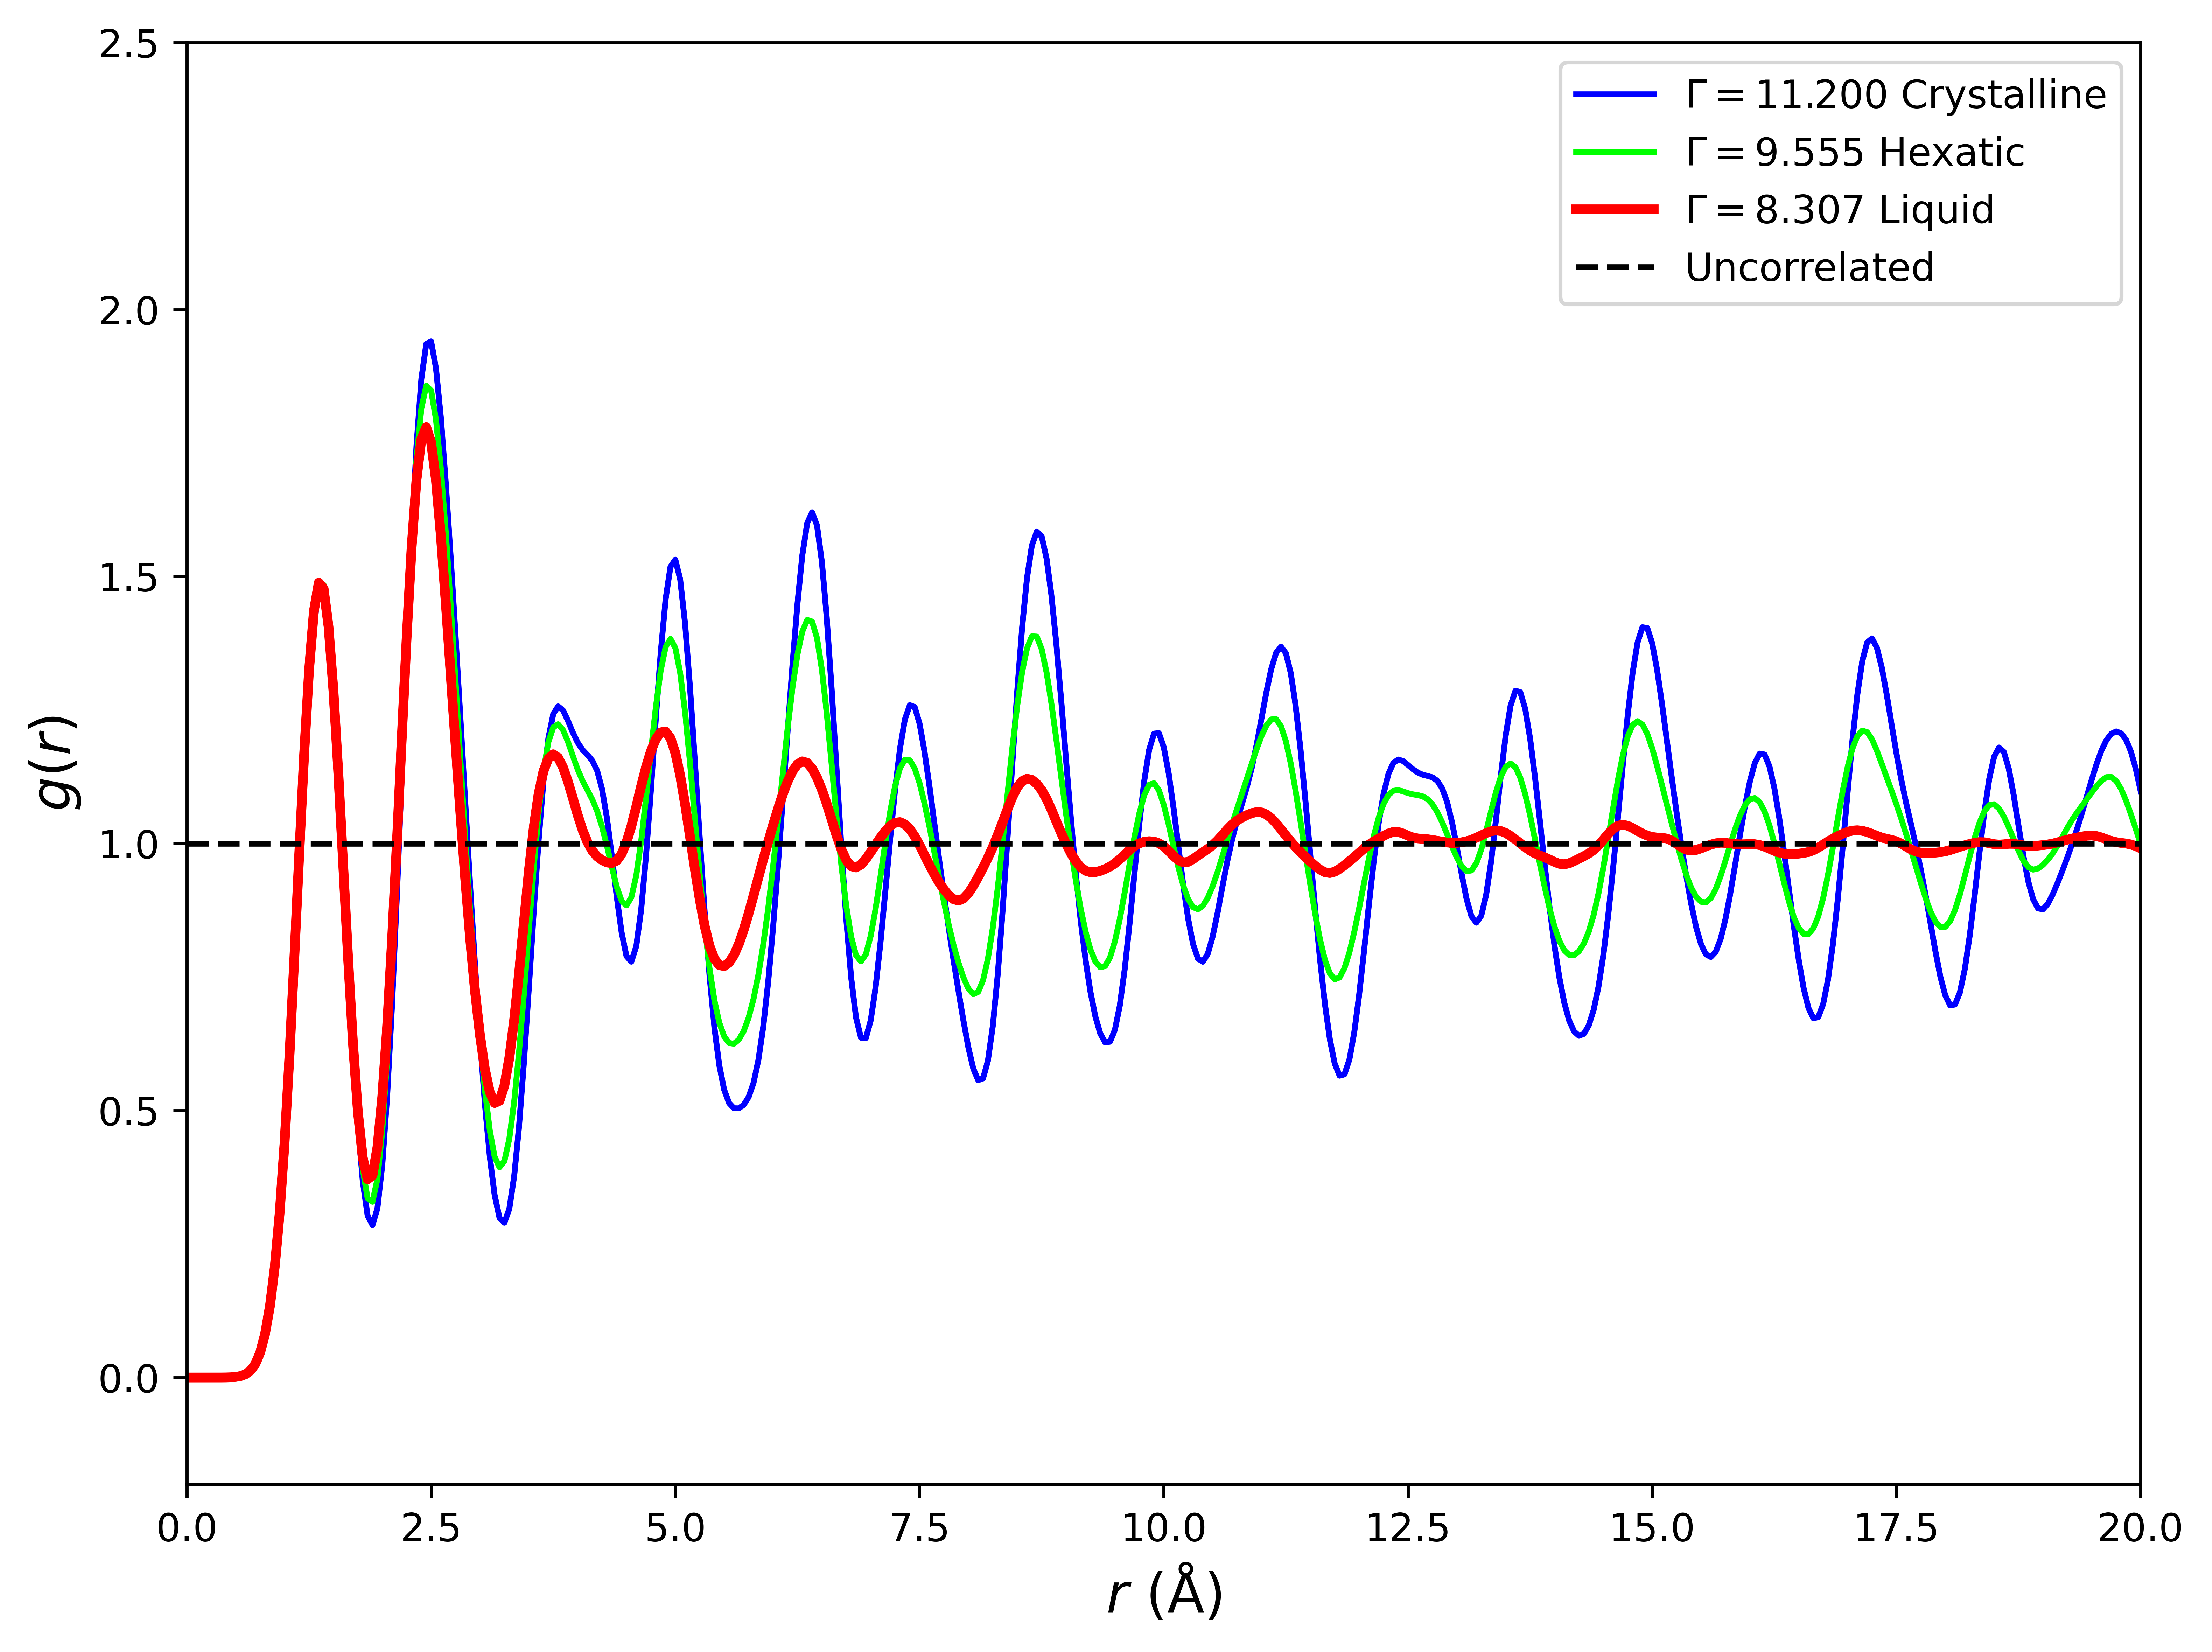

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from rdfpy import rdf

# List of temperatures and their corresponding dr values
temps = [(8350, r'$\Gamma = 11.200$ Crystalline', 1.5), (9750, r'$\Gamma = 9.555$ Hexatic',1.5), (10350, r'$\Gamma = 8.307$ Liquid',2.5)]
drs   = {8350: 0.05, 9750: 0.05, 10350: 0.05}
colors = {8350: 'blue', 9750: 'lime', 10350: 'red'}

plt.figure(figsize=(8, 6), dpi=800)

for T, G, lw, in temps:
    # Load positions, add a bit of noise
    data = np.loadtxt(f"../output/GAMMAS/{T}/anneal_{T}K.data",skiprows=15)
    pos  = data[:, 2:4]
    noise = np.random.normal(loc=0.0, scale=0.15, size=pos.shape)
    coords = pos + noise

    # Compute and smooth RDF
    g_r, radii = rdf(coords, dr=drs[T])
    g_smooth  = gaussian_filter1d(g_r, sigma=2)

    # Plot
    plt.plot(radii, g_smooth, color=colors[T], label=G, lw = lw)

# Reference line, axes limits and labels
plt.axhline(1, color='k', linestyle='--', label='Uncorrelated')
plt.xlim(0, 20)
plt.ylim(-0.2, 2.5)
plt.xlabel(r'$r$ (Å)', fontsize=14)
plt.ylabel(r'$g(r)$',   fontsize=14)
plt.legend()

# Save and show
plt.tight_layout()
plt.savefig("rdf_comparison.pdf")
plt.show()
